In [1]:
#Install elastic search
!pip install elasticsearch


In [2]:
!pip install -q pandas openai

In [3]:
import requests
import datetime
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch
from pandas import DataFrame
import numpy as np
es = Elasticsearch("http://localhost:9200")  # Change if your ES is hosted elsewhere

In [4]:
# Check if the index exists
index_exists = es.indices.exists(index="github_issues")
print("Index Exists:", index_exists)




Index Exists: True


In [5]:
# Check some entries to understand the data structure and date format
sample_issues = es.search(index="github_issues", body={"query": {"match_all": {}}}, size=10)
for issue in sample_issues['hits']['hits']:
    print(issue['_source'])


C:\Users\visma\AppData\Local\Temp\ipykernel_30472\3979613468.py:2: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  sample_issues = es.search(index="github_issues", body={"query": {"match_all": {}}}, size=10)


{'_type': 'issue', '_repo': 'elasticsearch', '_issueNumber': '105928', '_title': '[ML] Anomaly detection job reset can get stuck with no way to unblock', '_createdAt': '2024-03-04T18:15:53Z', '_closedAt': '2024-03-11T15:40:24Z', '_state': 'closed', '_body': 'When an anomaly detection job is reset we start a local (non-persistent) task to do the resetting operations.\r\n\r\nIt is possible for this task to disappear before it completes. One well-known way this can happen is if the node it is running on dies while it is running.\r\n\r\nLooking at the code, you\'d think that a way to unblock the reset would be to call the reset endpoint again for the same job. It appears that `resetIfJobIsStillBlockedOnReset` will be called from here: https://github.com/elastic/elasticsearch/blob/f77c16b78bab5e9f3ee24974aeba408e254e8c94/x-pack/plugin/ml/src/main/java/org/elasticsearch/xpack/ml/action/TransportResetJobAction.java#L127\r\n\r\nHowever, this doesn\'t happen if the original task disappeared wit

In [6]:
# Simple diagnostic query to fetch count of all documents
response = es.count(index="github_issues")
print("Total documents in index:", response['count'])


Total documents in index: 2373


Issues fetched: 2373


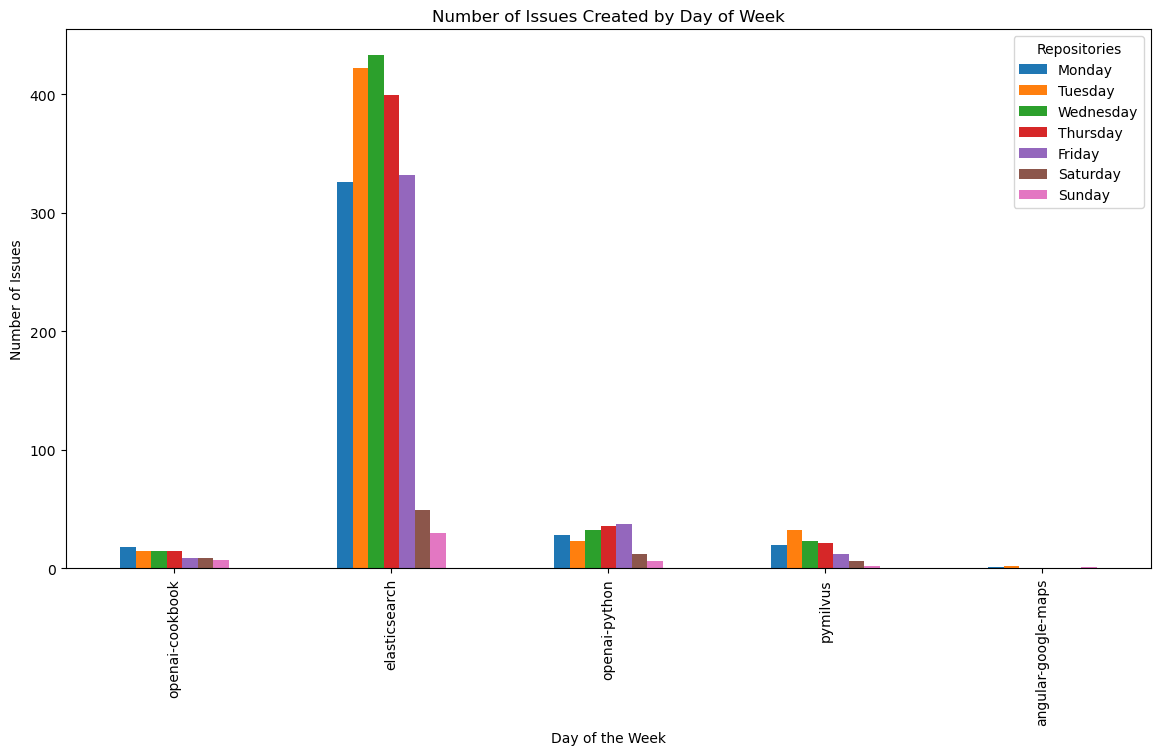

In [8]:
from datetime import datetime
import dateutil.parser
import pandas as pd

def fetch_and_process_issues():
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    repos = ["openai-cookbook", "elasticsearch", "openai-python", "pymilvus", "angular-google-maps"]
    results = {repo: {day: 0 for day in days_of_week} for repo in repos}

    # Fetch all issues from the Elasticsearch index
    issues_query = {
        "query": {
            "match_all": {}
        },
        "size": 2500  # Adjust this based on the expected number of issues
    }
    response = es.search(index="github_issues", body=issues_query)
    print("Issues fetched:", len(response['hits']['hits']))

    # Process each issue to determine the day of the week it was created
    for issue in response['hits']['hits']:
        created_at = dateutil.parser.parse(issue['_source']['_createdAt'])
        day_of_week = created_at.strftime('%A')
        repo_name = issue['_source']['_repo']
        if repo_name in results:  # Ensure the repo name matches
            results[repo_name][day_of_week] += 1

    return results

data = fetch_and_process_issues()
df = pd.DataFrame(data)
df = df.T  # Transpose to switch rows and columns for better graph display
df.plot(kind='bar', figsize=(14, 7))
plt.title("Number of Issues Created by Day of Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Issues")
plt.legend(title="Repositories")
plt.show()


In [12]:
def find_similar_issues(repo_name, issue_id):
    query = {
        "size": 5,
        "query": {
            "bool": {
                "must": [
                    {"match": {"repo": repo_name}}
                ],
                "should": [
                    {
                        "script_score": {
                            "query": {"match_all": {}},
                            "script": {
                                "source": "cosineSimilarity(params.query_vector, 'embeddings') + 1.0",
                                "params": {"query_vector": get_embeddings_for_issue(issue_id)}
                            }
                        }
                    }
                ]
            }
        }
    }
    response = es.search(index="github_issues", body=query)
    return [(hit['_source']['title'], hit['_score']) for hit in response['hits']['hits']]

# Function to get embeddings from the issue text, similar to what you might have used for indexing
def get_embeddings_for_issue(issue_id):
    # This function should return the vector embeddings stored in ES for a given issue ID
    # Here, I'm assuming it fetches the embeddings directly from the indexed data
    pass

# Example usage
openai_cookbook_similar_issues = find_similar_issues("openai-cookbook", "1161")
print(openai_cookbook_similar_issues)
print("Top 5 openai-cookbook Similar Issues:")
for title, score in openai_cookbook_similar_issues:
    print(f"Title: {title}, Score: {score}")


[]
Top 5 openai-cookbook Similar Issues:


In [25]:
def get_embeddings_for_issue(issue_number):
    # Elasticsearch query to retrieve embeddings based on issue number
    query = {
        "query": {
            "match": {
                "_issueNumber": issue_number
            }
        }
    }

    # Send the query to Elasticsearch
    response = es.search(index="github_issues", body=query)

    # Check if any hits were found
    if response['hits']['total']['value'] > 0:
        # Retrieve the embeddings from the first hit
        embeddings = response['hits']['hits'][0]['_source']['GitHub_Issue_vector']
        return embeddings
    else:
        # If no hits were found, return None
        print("None")
        return None


In [55]:
from tabulate import tabulate
def find_similar_issues(repo_name, issue_number):
    query = {
        "size": 5,
        "query": {
            "bool": {
                "must": [
                    {"match": {"_repo": repo_name}}
                ],
                "should": [
                    {
                        "script_score": {
                            "query": {"match_all": {}},
                            "script": {
                                "source": "cosineSimilarity(params.query_vector, 'GitHub_Issue_vector') + 1.0",
                                "params": {"query_vector": get_embeddings_for_issue(issue_number)}
                            }
                        }
                    }
                ]
            }
        }
    }
    response = es.search(index="github_issues", body=query)
    similar_issues = []
    for hit in response['hits']['hits']:
        issue_info = {
            "title": hit['_source']['_title'],
            "issue_number": hit['_source']['_issueNumber'],
            "repo": hit['_source']['_repo'],
            "created_at": hit['_source']['_createdAt'],
            "closed_at": hit['_source']['_closedAt'],
            "state": hit['_source']['_state'],
            #"body": hit['_source']['_body'],
            "score": hit['_score']
        }
        similar_issues.append(issue_info)
    headers = similar_issues[0].keys()
    rows = [issue.values() for issue in similar_issues]
    print(tabulate(rows, headers=headers, tablefmt="grid"))





<div class="alert alert-info">   
    
OpenAI CookBook 5 Similar Issues based on the issueNumber=1161

    
</div>

In [49]:
issueNum=1161
repositoryName="openai-cookbook"
find_similar_issues(repositoryName, issueNum)

+----------------------+----------------+-----------------+----------------------+----------------------+---------+----------------------------------------------------------+---------+
| title                |   issue_number | repo            | created_at           | closed_at            | state   | body                                                     |   score |
+======================+================+=================+======================+======================+=========+==========================================================+=========+
| Update registry.yaml |           1161 | openai-cookbook | 2024-04-19T18:32:11Z | 2024-04-19T19:05:01Z | closed  | forgot to update registry.yaml with modified filename.   | 6.14287 |
+----------------------+----------------+-----------------+----------------------+----------------------+---------+----------------------------------------------------------+---------+
| Update registry.yaml |           1088 | openai-cookbook | 2024-03-05T16:5

<div class="alert alert-info">   
    
Elastic Search 5 Similar Issues based on the issueNumber=105928

    
</div>

In [58]:
issueNum=105928
repositoryName="elasticsearch"
find_similar_issues(repositoryName, issueNum)

+------------------------------------------------------------------------------------------------+----------------+---------------+----------------------+----------------------+---------+---------+
| title                                                                                          |   issue_number | repo          | created_at           | closed_at            | state   |   score |
+================================================================================================+================+===============+======================+======================+=========+=========+
| [ML] Anomaly detection job reset can get stuck with no way to unblock                          |         105928 | elasticsearch | 2024-03-04T18:15:53Z | 2024-03-11T15:40:24Z | closed  | 2.18335 |
+------------------------------------------------------------------------------------------------+----------------+---------------+----------------------+----------------------+---------+---------+
| During M

<div class="alert alert-info">   
    
OpenAI-Python 5 Similar Issues based on the issueNumber=1352

    
</div>

In [57]:
issueNum=1352
repositoryName="openai-python"
find_similar_issues(repositoryName, issueNum)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------+----------------------+----------------------+---------+---------+
| title                                                                                                                                                                                                                                                                                   |   issue_number | repo          | created_at           | closed_at            | state   |   score |
+=========================================================================================================================================================================================================================================

<div class="alert alert-info">   
    
pymilvus 5 Similar Issues based on the issueNumber=2046

    
</div>

In [56]:
issueNum=2046
repositoryName="pymilvus"
find_similar_issues(repositoryName, issueNum)

+-------------------------------------------------------------------------------------------------------------------------------------+----------------+----------+----------------------+----------------------+---------+---------+
| title                                                                                                                               |   issue_number | repo     | created_at           | closed_at            | state   |   score |
+=====================================================================================================================================+================+==========+======================+======================+=========+=========+
| [Bug]: FieldSchema.construct_from_dict() not support params  max_length and dim                                                     |           2046 | pymilvus | 2024-04-18T12:23:51Z | 2024-12-31T00:36:30Z | open    | 5.14591 |
+-------------------------------------------------------------------------------

<div class="alert alert-info">   
    
angular-google-maps 5 Similar Issues based on the issueNumber=2048

    
</div>

In [59]:
issueNum=2048
repositoryName="angular-google-maps"
find_similar_issues(repositoryName, issueNum)

+-----------------------------------------+----------------+---------------------+----------------------+----------------------+---------+---------+
| title                                   |   issue_number | repo                | created_at           | closed_at            | state   |   score |
+=========================================+================+=====================+======================+======================+=========+=========+
| chore: Migrate repo from Ng 14 to Ng 15 |           2048 | angular-google-maps | 2024-03-26T17:09:42Z | 2024-03-26T17:17:03Z | closed  | 13.1086 |
+-----------------------------------------+----------------+---------------------+----------------------+----------------------+---------+---------+
| Migration from Angular 14 to Angular 15 |           2046 | angular-google-maps | 2024-03-10T18:42:03Z | 2024-03-26T17:16:53Z | closed  | 13.0375 |
+-----------------------------------------+----------------+---------------------+----------------------+-